Base de datos: OASIS

In [22]:
import os
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import nibabel as nib
import scipy.ndimage as ndi
import scipy.ndimage as ndi
import pandas as pd
import seaborn as sns
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from sklearn.model_selection import train_test_split

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Voy a tomar valores de imágenes que si tengan el label de CDR, para ello accedo al csv que proporciona la base de datos y selecciono 200

In [52]:
csv_file = '/content/drive/MyDrive/Proyecto_Patrones/oasis1_cross_sectional.csv'
df = pd.read_csv(csv_file)
filtered_df = df[df['CDR'].notna()]
selected_rows = filtered_df.head(100)
labels = selected_rows['CDR'].tolist()
id_values = selected_rows['ID'].tolist()
print(len(labels))

100


Ahora voy a delimitar mi lista de folders a esos folders que si tienen un valor no nulo de CDR

In [53]:
base_folder_path = '/content/drive/MyDrive/Proyecto_Patrones/data/'
folders = []
for id_value in id_values:
    folder_path = os.path.join(base_folder_path, id_value)
    folders.append(folder_path)
print(f"Número de imágenes de {base_folder_path}: {len(folders)}")

Número de imágenes de /content/drive/MyDrive/Proyecto_Patrones/data/: 100


In [54]:

images = []

for folder in folders:
    folder_path = os.path.join(base_folder_path, folder)
    fsl_seg_path = os.path.join(folder_path, 'FSL_SEG')
    files_in_fsl_seg = os.listdir(fsl_seg_path)

    hdr_files = [file for file in files_in_fsl_seg if file.endswith('.hdr')]

    for hdr_file in hdr_files:
        hdr_file_path = os.path.join(fsl_seg_path, hdr_file)
        brain_vol = nib.load(hdr_file_path)
        brain_vol_data = brain_vol.get_fdata()
        mean_image = np.mean(brain_vol_data[:, :, 70:100], axis=2) #promediamos estos slices del volumen porque son los que tienen más información
        resized_mean_image = tf.image.resize(mean_image, [128, 128])
        images.append(resized_mean_image)

print(len(images)) #verificamos que es la cantidad de imágenes que queremos
print(len(labels))

100
100


In [11]:
mean_image = np.mean(brain_vol_data[:, :, 70:100], axis=2)
print(mean_image.shape) #revisamos el tamaño de las imágenes para ver si es que la estandarizacion previa de 128x128 nos quita mucha info

(176, 208, 1)


In [55]:
images = np.array(images)
labels = np.array(labels)
print(labels)
labels = labels.astype(float)
print(labels)

[0.  0.  0.5 0.  0.  0.  0.5 0.5 0.  0.  0.  0.5 0.5 0.5 0.  1.  0.  1.
 0.  0.  0.  1.  0.5 0.5 0.5 0.  0.5 1.  1.  1.  0.  0.5 0.  0.  0.  0.5
 1.  0.  0.  0.  0.  0.  1.  0.  0.  0.  0.5 0.  0.5 0.  0.  0.5 0.  0.5
 0.  0.  0.  0.  0.  0.  0.5 0.  0.5 1.  0.5 0.5 0.  0.  1.  0.  1.  0.
 0.  0.5 0.5 0.  0.5 0.  0.5 0.5 0.5 0.  0.5 0.  0.  0.  0.  0.5 0.  0.
 1.  1.  0.  0.  0.  0.  0.  0.  0.  0. ]
[0.  0.  0.5 0.  0.  0.  0.5 0.5 0.  0.  0.  0.5 0.5 0.5 0.  1.  0.  1.
 0.  0.  0.  1.  0.5 0.5 0.5 0.  0.5 1.  1.  1.  0.  0.5 0.  0.  0.  0.5
 1.  0.  0.  0.  0.  0.  1.  0.  0.  0.  0.5 0.  0.5 0.  0.  0.5 0.  0.5
 0.  0.  0.  0.  0.  0.  0.5 0.  0.5 1.  0.5 0.5 0.  0.  1.  0.  1.  0.
 0.  0.5 0.5 0.  0.5 0.  0.5 0.5 0.5 0.  0.5 0.  0.  0.  0.  0.5 0.  0.
 1.  1.  0.  0.  0.  0.  0.  0.  0.  0. ]


In [56]:
images = images / 255.0

X_train, X_val, y_train, y_val = train_test_split(images, labels, test_size=0.2, random_state=42)

model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(128, 128, 1)),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    #Dense(1, activation='sigmoid')  # Use 'softmax' if you have more than 2 classes
    Dense(3, activation='softmax')
])

In [57]:
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [58]:
history = model.fit(X_train, y_train, epochs=20, validation_data=(X_val, y_val))

Epoch 1/20
3/3 [==============================] - 6s 1s/step - loss: 1.0570 - accuracy: 0.5375 - val_loss: 0.6353 - val_accuracy: 0.5500
Epoch 2/20
3/3 [==============================] - 2s 706ms/step - loss: 0.5020 - accuracy: 0.6000 - val_loss: 0.5676 - val_accuracy: 0.5500
Epoch 3/20
3/3 [==============================] - 2s 679ms/step - loss: 0.6123 - accuracy: 0.6000 - val_loss: 0.3413 - val_accuracy: 0.5500
Epoch 4/20
3/3 [==============================] - 2s 681ms/step - loss: 0.4799 - accuracy: 0.6000 - val_loss: 0.4214 - val_accuracy: 0.5500
Epoch 5/20
3/3 [==============================] - 2s 695ms/step - loss: 0.5319 - accuracy: 0.5875 - val_loss: 0.4449 - val_accuracy: 0.5500
Epoch 6/20
3/3 [==============================] - 3s 1s/step - loss: 0.4857 - accuracy: 0.6000 - val_loss: 0.3384 - val_accuracy: 0.5500
Epoch 7/20
3/3 [==============================] - 4s 1s/step - loss: 0.4825 - accuracy: 0.6000 - val_loss: 0.3278 - val_accuracy: 0.5500
Epoch 8/20
3/3 [=============

1/1 [==============================] - 1s 638ms/step - loss: 0.3258 - accuracy: 0.5500

Test accuracy: 0.550000011920929

Test loss: 0.3257938623428345


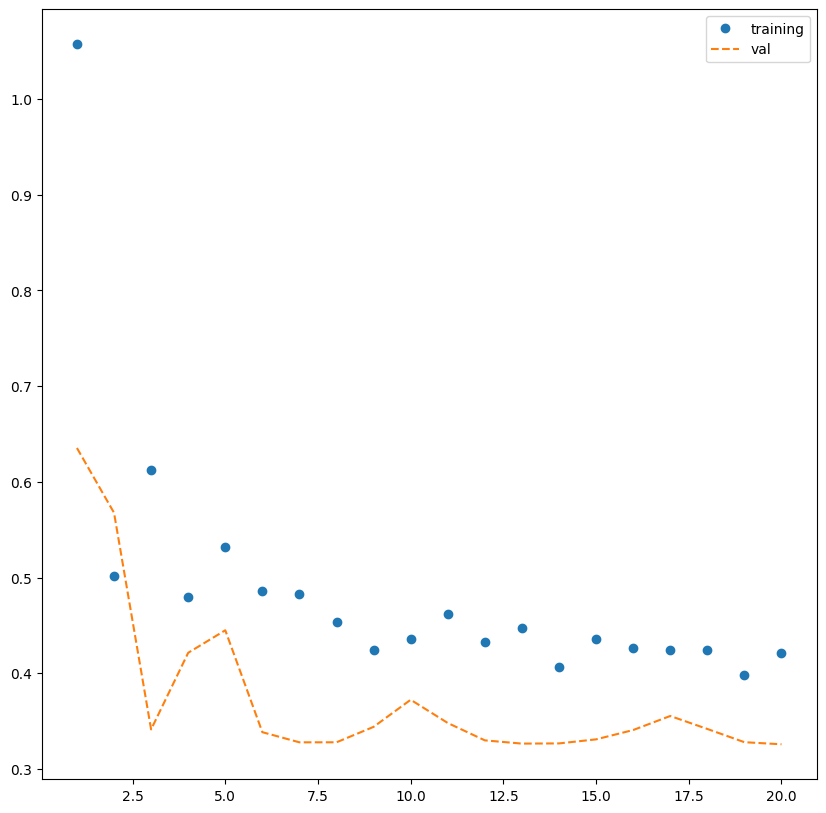

In [59]:
test_loss, test_acc = model.evaluate(X_val, y_val)
print('\nTest accuracy:', test_acc)
print('\nTest loss:', test_loss)

history_dict = history.history
loss_values = history_dict['loss']
val_loss_values = history_dict['val_loss']

fig = plt.figure(figsize=(10,10))
epoch = range(1,len(loss_values)+1)
plt.plot(epoch,loss_values, 'o',label='training')
plt.plot(epoch,val_loss_values, '--',label='val')
plt.legend()
plt.show()

Añadiendo regularizador

In [60]:
from keras import regularizers

model_reg = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(128, 128, 1)),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.01)),
    Dropout(0.5),
    Dense(3, activation='softmax')
])
model_reg.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [62]:
history = model_reg.fit(X_train, y_train, epochs=20, validation_data=(X_val, y_val))

Epoch 1/20
3/3 [==============================] - 8s 3s/step - loss: 3.2649 - accuracy: 0.5875 - val_loss: 2.1680 - val_accuracy: 0.5500
Epoch 2/20
3/3 [==============================] - 2s 741ms/step - loss: 1.8413 - accuracy: 0.6000 - val_loss: 1.0813 - val_accuracy: 0.5500
Epoch 3/20
3/3 [==============================] - 2s 720ms/step - loss: 1.1557 - accuracy: 0.6000 - val_loss: 0.7000 - val_accuracy: 0.5500
Epoch 4/20
3/3 [==============================] - 2s 745ms/step - loss: 0.7777 - accuracy: 0.6000 - val_loss: 0.5561 - val_accuracy: 0.5500
Epoch 5/20
3/3 [==============================] - 2s 768ms/step - loss: 0.6517 - accuracy: 0.5875 - val_loss: 0.4944 - val_accuracy: 0.5500
Epoch 6/20
3/3 [==============================] - 4s 1s/step - loss: 0.6029 - accuracy: 0.6000 - val_loss: 0.4865 - val_accuracy: 0.5500
Epoch 7/20
3/3 [==============================] - 3s 994ms/step - loss: 0.5599 - accuracy: 0.6000 - val_loss: 0.4922 - val_accuracy: 0.5500
Epoch 8/20
3/3 [==========

1/1 [==============================] - 0s 170ms/step - loss: 0.3764 - accuracy: 0.5500

Test accuracy: 0.550000011920929

Test loss: 0.3764290511608124


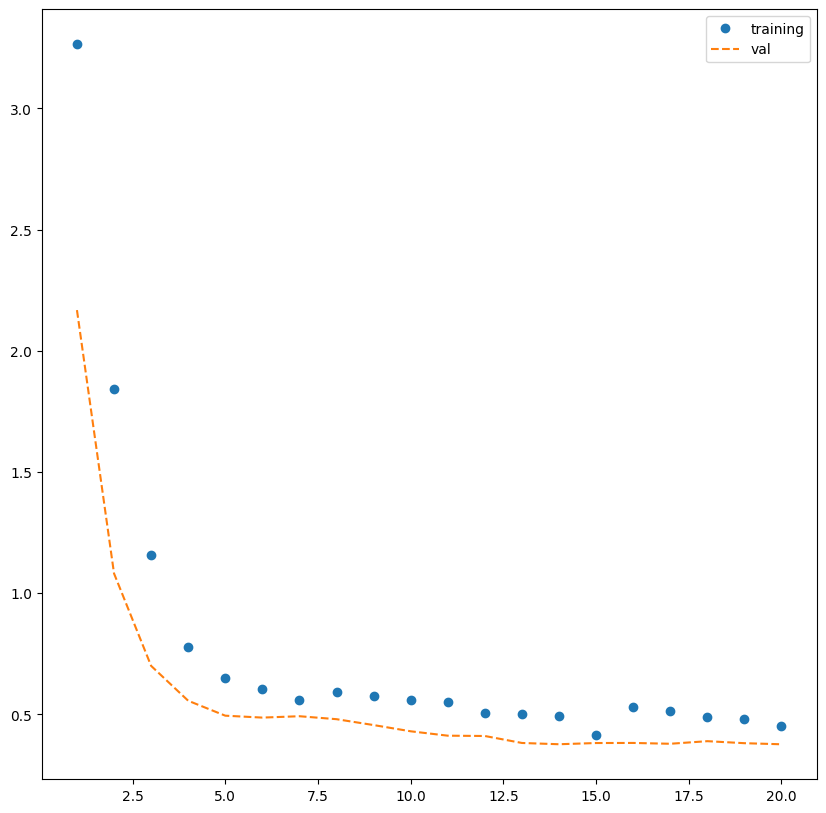

In [63]:
test_loss, test_acc = model_reg.evaluate(X_val, y_val)
print('\nTest accuracy:', test_acc)
print('\nTest loss:', test_loss)

history_dict = history.history
loss_values = history_dict['loss']
val_loss_values = history_dict['val_loss']

fig = plt.figure(figsize=(10,10))
epoch = range(1,len(loss_values)+1)
plt.plot(epoch,loss_values, 'o',label='training')
plt.plot(epoch,val_loss_values, '--',label='val')
plt.legend()
plt.show()